# Анализ влияния маркетинговых инструментов на спрос на автомобили

## Введение

### Общее описание
Заказчиком представлены временные ряды предикторов и целевого показателя (суммарное количество телефонных звонков возможных покупателей в дилерские центры, реализующие автомобиль определённой марки). Необходимо разработать решение, которое позволит прогнозировать количество телефонных звонков неуникальных потенциальных покупателей в справочные дилерских центров.

### Задача
Построить регрессионную модель предсказания телефонных звонков неуникальных потенциальных покупателей в справочные дилерских центров в зависимости от входных признаков.

### Описание данных

Данные представляют собой временные ряды с шагом 1 день.

- `'Date'` - Дата (дни с 1 января 2013 года по 1 февраля 2015 года, формат: MM.DD.YYYY);
- `'Y'` - Целевой показатель - суммарное количество телефонных звонков неуникальных потенциальных покупателей в справочные дилерских центров, реализующих автомобиль изучаемой марки (шт);
- `'TV'` - Показатель медиа активности на национальном телевидении (реклама изучаемой марки авто), оценка числа контактов (в тысячах) с целевой аудиторией (OTS, opportunity to see)
- `'OOH'` - OTS по наружной рекламе - оценка числа контактов (в тысячах) с целевой аудиторией за соответствующий месяц (например, значение 39075 от 01.03.2013 означает, что в течение марта 2013 года было 39075000 контактов ЦА с наружной рекламой);
- `'Seasonal_Sales'` - Нормированная в шкалу от 0 (минимум) до 1 (максимум) оценка сезонной составляющей продаж автомобилей изучаемой марки в помесячной детализации;
- `'usd_rate'` - Курс доллара по Yahoo Finance (рублей за 1 доллар).

### План работ
- Загрузить данные
- Выполнить предобработку данных
- Провести EDA
- Обучить модели для прогнозирования таргета, оценить качество лучшей модели
- Объяснить важность признаков модели
- Оформить рекомендации для Заказчика

## Import dependencies

In [1]:
#!pip install numpy -q
#!pip install matplotlib -q
#!pip install pandas -q
#!pip install seaborn -q
#!pip install scikit-learn -q
#!pip install scipy -q
#!pip install numba -q
#!pip install shap -q
#!pip install phik -q
#!pip install lightgbm -q
#!pip install statsmodels -q

In [2]:
import warnings 
warnings.filterwarnings('ignore', category=UserWarning)

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import (
    train_test_split, RandomizedSearchCV, TimeSeriesSplit
)
from sklearn.preprocessing import (StandardScaler, OneHotEncoder)
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error
import scipy.stats as st
from lightgbm import LGBMRegressor
from phik import phik_matrix
import shap
from statsmodels.tsa.seasonal import seasonal_decompose

## Загрузка и предобработка данных

### Загрузка и первоначальное изучение

In [34]:
path = 'https://drive.google.com/uc?export=download&id=1ZMOsh_9cwL5Yxqj-AuRxrp-X6JMk7tOi'
data = pd.read_excel(path, sheet_name='Raw data')
data.head()

,Date,Y,TV,OOH,Seasonal_Sales,Usd_rate
0,2013-01-01,NaN,0,0.0,0.060802,30.502001
1,2013-01-02,0.0,0,0.0,0.060802,30.337200
2,2013-01-03,17.0,0,0.0,0.060802,30.156500
3,2013-01-04,17.0,0,0.0,0.060802,30.271000
4,2013-01-05,8.0,0,0.0,0.060802,30.271000


Обработаем названия столбцов для более удобной работы.

In [5]:
data.columns = data.columns.str.lower()

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 762 entries, 0 to 761
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date            762 non-null    datetime64[ns]
 1   y               759 non-null    float64       
 2   tv              762 non-null    int64         
 3   ooh             762 non-null    float64       
 4   seasonal_sales  762 non-null    float64       
 5   usd_rate        762 non-null    float64       
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 35.8 KB


Данные соответствуют описанию. Обратим внимание, что есть явные пропуски в целевом признаке, обработаем их далее.

### Предобработка данных

#### Пропущенные значения

Пропуски содержатся в целевой переменной, проверим, что это за дни.

В других колонках пропусков нет.

In [7]:
data[data['y'].isna()]

,date,y,tv,ooh,seasonal_sales,usd_rate
0,2013-01-01,NaN,0,0.0,0.060802,30.502001
365,2014-01-01,NaN,0,0.0,0.060802,32.683201
730,2015-01-01,NaN,0,0.0,0.060802,60.700001


Это первое января каждого года. Будем считать, что в эти дни звонков не было, так как это выходной день у всех, и заполним данные нулями. 

In [8]:
data = data.fillna(0)
data.isna().sum()

date              0
y                 0
tv                0
ooh               0
seasonal_sales    0
usd_rate          0
dtype: int64

Пропуски обработаны, можно двигаться дальше.

#### Дубликаты

Проверим, есть ли в данных явные дубликаты.

In [9]:
data.duplicated().sum()

0

Дополнительно проверим, все ли даты уникальны.

In [10]:
data.duplicated(subset=['date']).sum()

0

Явные дубликаты отсутствуют.

**Вывод по загрузке и предобработке данных**

- Данные соответствуют описанию;
- Названия колонок приведены в нижний регистр;
- Обработаны пропуски;
- Явные дубликаты в данных отсутствуют.

## Разведочный анализ данных (EDA)

Изучим распределения признаков.

#### Входные признаки

Изучим сначала распределения исходных признаков с помощью гистограмм и основных описательных статистик, далее посмотрим на графики зависимости входных признаков от даты.

In [11]:
# Функция для отображения гистограммы
# feature_name_string - заголовок для графика
def display_hist(feature, dataframe, bins=30):
    dataframe[feature].plot(
        kind='hist', y=feature, bins=bins, color='g', alpha=0.5
    )
    plt.title(f'Распределение признака {feature}')
    plt.ylabel('Частота')
    plt.show()
    print(data[feature].describe())

In [12]:
# Функция для отображения зависимости признака от даты
def display_ts(feature, dataframe):
    dataframe[feature].plot(y=feature, figsize=(10,6))
    plt.title(f'Зависимость {feature} от даты')
    plt.xlabel('Дата')
    plt.ylabel(feature)
    plt.show()

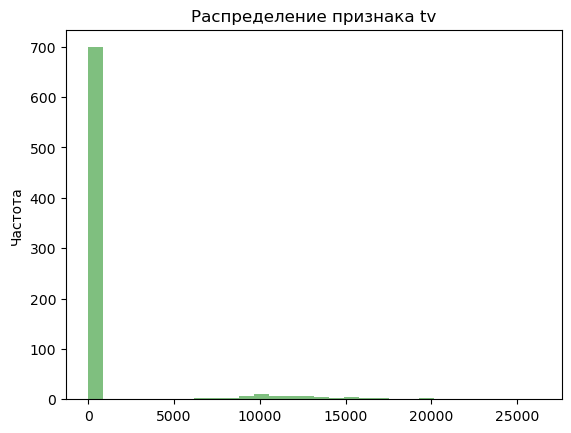

count      762.000000
mean      1040.011811
std       3645.686335
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      26310.000000
Name: tv, dtype: float64


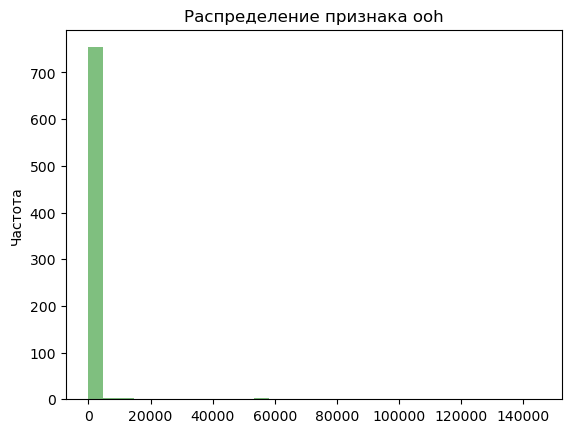

count       762.000000
mean        468.645669
std        6208.391584
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max      145137.000000
Name: ooh, dtype: float64


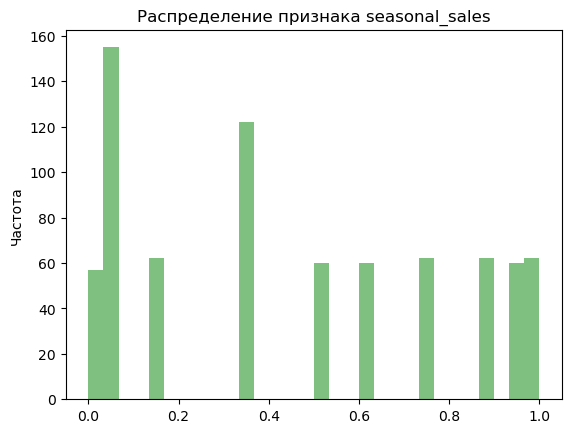

count    762.000000
mean       0.460017
std        0.353072
min        0.000000
25%        0.062488
50%        0.360924
75%        0.759700
max        1.000000
Name: seasonal_sales, dtype: float64


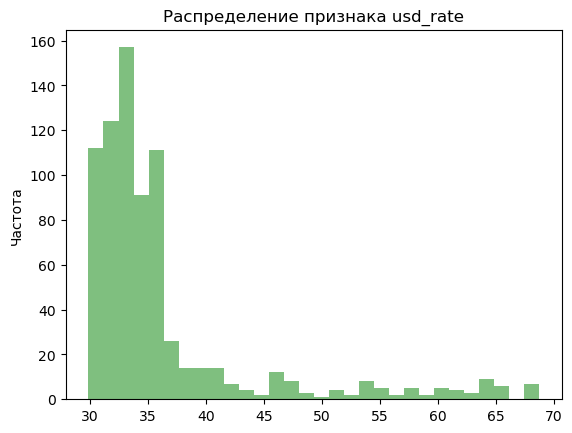

count    762.000000
mean      36.330886
std        8.022390
min       29.883301
25%       32.113201
50%       33.413300
75%       36.036124
max       68.735001
Name: usd_rate, dtype: float64


In [13]:
# Список для хранения названий колонок
num_features = ['tv', 'ooh', 'seasonal_sales', 'usd_rate']


for feature in num_features:
    display_hist(feature, data)

Интерпретация
- Более 75% значений признаков tv и ooh равны нулю, то есть в большинстве случаев не было контактов через телевидение и наружную рекламу, изучим далее эти признаки в зависимости от даты, чтобы понять, как происходило взаимодействие с пользователями через эти виды рекламы (возможно, они происходили с какой-то периодичностью, в бизнес-логику этих признаков это укладывается: баннер висел n дней, его увидели m человек, а в остальные дни баннер не висел, и его увидели 0 человек, с телевидением аналогично);
- Распределение оценки сезонности почти равномерное, но есть два наиболее частых значения - 0.06 и 0.36, выбросы и аномалии отсутствуют.

In [14]:
# Поставим дату в индекс для более удобной визуализации
data = data.set_index('date')

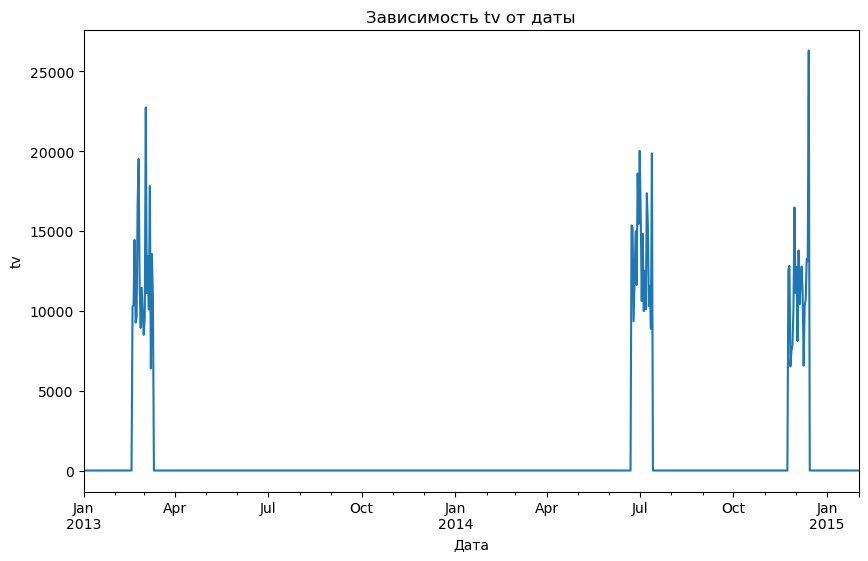

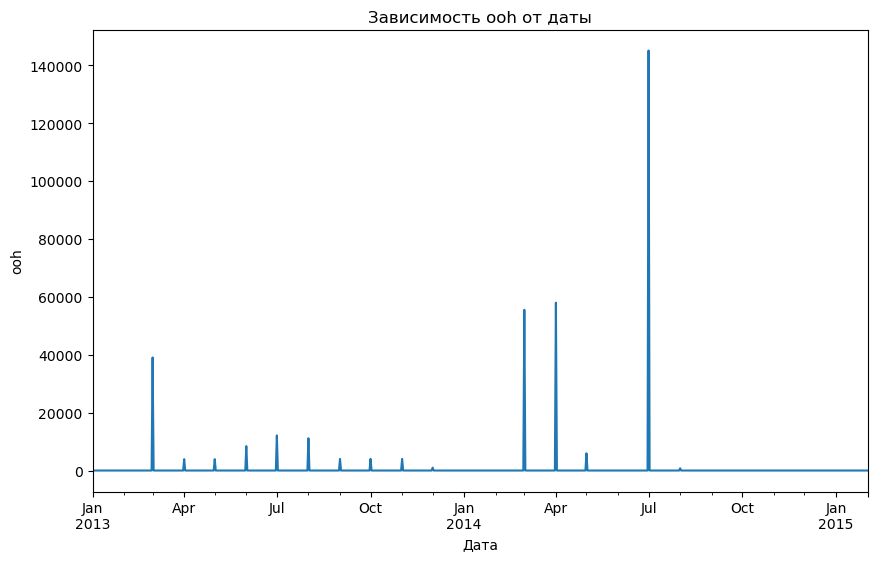

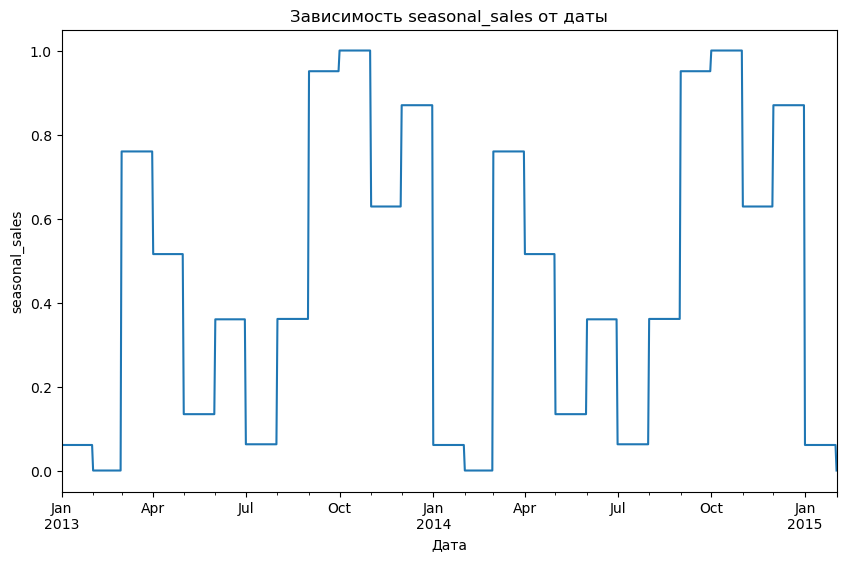

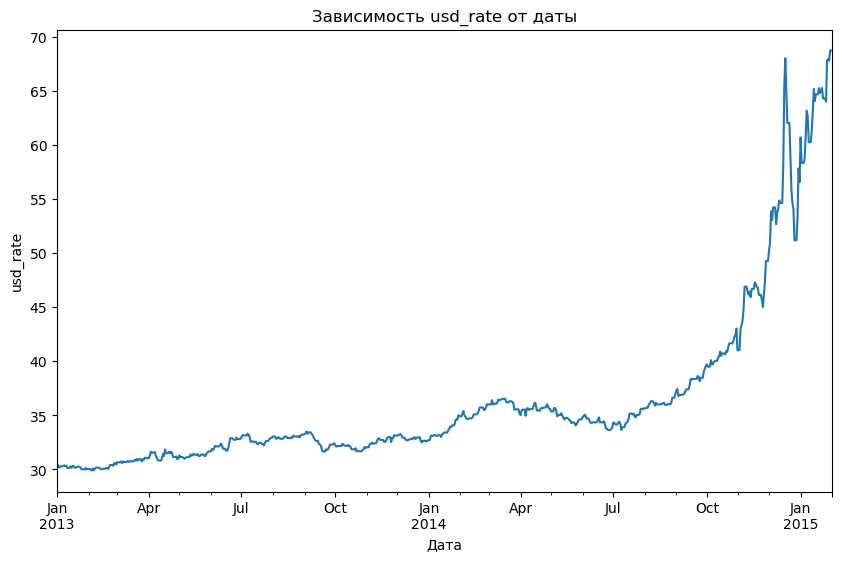

In [15]:
for feature in num_features:
    display_ts(feature, data)

Интерпретация
- Общие моменты: Так как в OOH и TV значения нулевые, кроме некоторых промежутков, можем считать, что канал просто не использовался в остальное время: то есть не было размещено баннера с рекламой и/или рекламного ролика;
- TV: На графике видно, что было 3 серии показов рекламы по ТВ: в 1 квартале 2013, в июне-августе 2014, и осенью 2015. Внутри каждого промежутка OTS распределялось по-разному, но имело похожую форму. Это может указывать на различия в стратегии показа или изменения в вовлечённости аудитории;
- OOH: На графике видно 15 промежутков, на которых отличные от нуля OTS. Причем, показатели OTS выше в марте 2013 и 2014, апреле 2014, а также в июле 2014. Это может указывать на тестирование разных комбинаций баннера и местоположения баннера, или с сезонными факторами, влияющими на охваты;
- Показатель оценка сезонности четко демонстрирует цикличность графике: Оценка растет с августа, заканчивая рост пиком в октябре (оценка 1), в ноябре небольшой спад, и в декабре снова демонстрируется локальный пик (0.8), за которым следует резкий спад почти до нуля. Январь и февраль - самые неактивные месяцы, в марте наступает резкий рост почти до уровня оценки в декабре, но за ним следует плавный спад, с локальным минимумом в мае, в июне оценка немного повышается, но в июле снова падает почти к нулю. Сентябрь, октябрь и декабрь - лучшие месяцы с точки зрения сезонности;
- Курс доллара начиная с октября 2014 начал стремительный рост, это могло значительно повлиять на рынок.

Двигаемся к целевому признаку.

#### Целевой признак - Количество звонков

**Гистограмма**

Изучим сначала форму распределения признака, для этого построим гистограмму и выведем основные статистики.

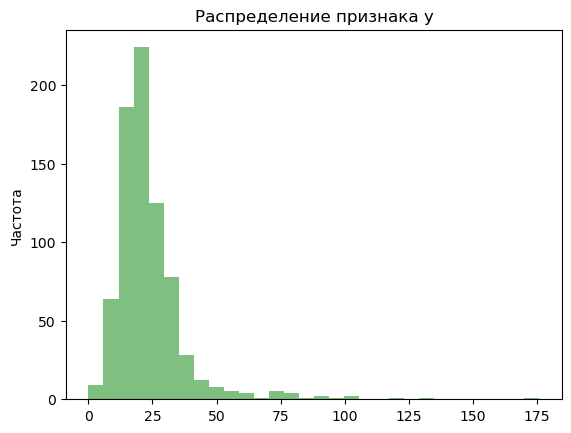

count    762.000000
mean      23.534121
std       15.124434
min        0.000000
25%       16.000000
50%       21.000000
75%       27.000000
max      176.000000
Name: y, dtype: float64


In [16]:
display_hist('y', data)

Интерпретация
- Распределение похоже на нормальное, чуть скошенного влево. Среднее 23.6, медиана чуть меньше - 21, это связано с наличием больших значений - 75 и более.

**Анализ временных рядов**

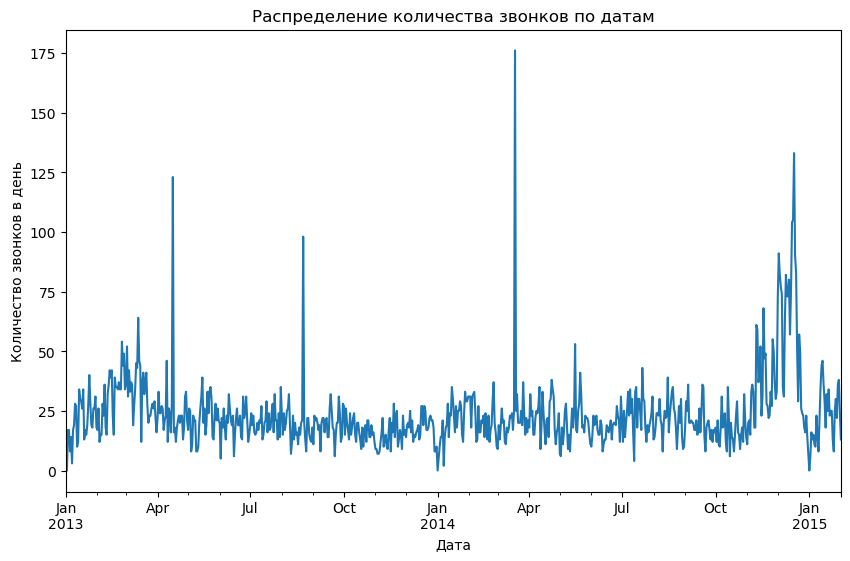

In [17]:
data['y'].plot(figsize=(10,6))
plt.title('Распределение количества звонков по датам')
plt.ylabel('Количество звонков в день')
plt.xlabel('Дата')
plt.show()

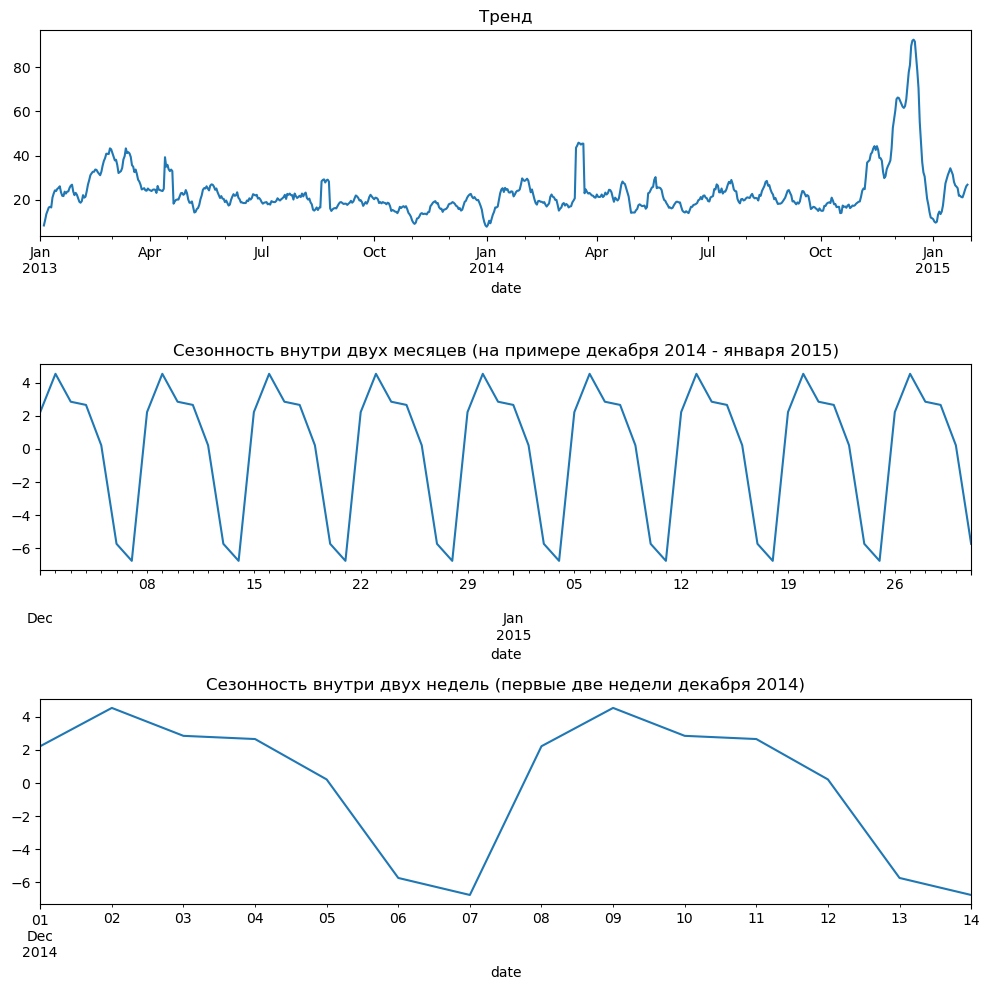

In [18]:
plt.figure(figsize=(10, 10))
plt.subplot(311)
seasonal_decompose(data['y']).trend.plot(ax=plt.gca())
plt.title('Тренд')


plt.subplot(312)
seasonal_decompose(data['y'].resample('1D').sum()).seasonal['2014-12-01':'2015-01-31'].plot(ax=plt.gca())
plt.title('Сезонность внутри двух месяцев (на примере декабря 2014 - января 2015)')


plt.subplot(313)
seasonal_decompose(data['y'].resample('1D').sum()).seasonal['2014-12-01':'2014-12-14'].plot(ax=plt.gca())
plt.title('Сезонность внутри двух недель (первые две недели декабря 2014)')


plt.tight_layout()

Интерпретация
- В нашем распоряжении данные с января 2013 по январь 2015;
- В конце 2014 года произошел небывалый рост, вслед за которым пришел сильный сезонный спад (январь и февраль худшие месяцы по оценке сезонности);
- Из анализа сезонности внутри двух недель (первые 14 дней декабря 2014 как раз идеально две полные недели): Присутствует сезонность в разрезе недели: с понелельника по вторник (пик) происходит рост, который переходит в плавное падение до пятницы, но в субботу и воскресенье происходит резкий спад почти до нуля.

**Создание новых признаков**

Исходя из анализа распределения временных рядов, создадим новые признаки:
1. Количество звоноков день назад (так как присутствует недельная сезонность);
2. Скользящее среднее с шагом 7 (так как присутствует недельная сезонность);
3. День недели;
4. Месяц.

#### Создание новых признаков

Используя выводы предыдущего раздела, добавим в датасет новые признаки..

In [19]:
# Используем функцию для автоматического создания признаков
def add_features(dataframe):
    dataframe['week_day'] = data.index.dayofweek
    dataframe['month'] = data.index.month
    dataframe['rolling_mean'] = dataframe['y'].shift().rolling(7).mean()
    for lag in range(1, 8):
        dataframe[f'lag_{lag}'] = dataframe['y'].shift(lag)


add_features(data)
data.isna().sum()

y                 0
tv                0
ooh               0
seasonal_sales    0
usd_rate          0
week_day          0
month             0
rolling_mean      7
lag_1             1
lag_2             2
lag_3             3
lag_4             4
lag_5             5
lag_6             6
lag_7             7
dtype: int64

Функция создала нам несколько строк с пустыми значениями скользящего среднего и лагов, потому что в расчетах используются данные из предыдущего периода, а таких данных у нас нет, поэтому просто удалим эти строки.

In [20]:
data = data.dropna()
data.isna().sum()

y                 0
tv                0
ooh               0
seasonal_sales    0
usd_rate          0
week_day          0
month             0
rolling_mean      0
lag_1             0
lag_2             0
lag_3             0
lag_4             0
lag_5             0
lag_6             0
lag_7             0
dtype: int64

#### Корреляционный анализ

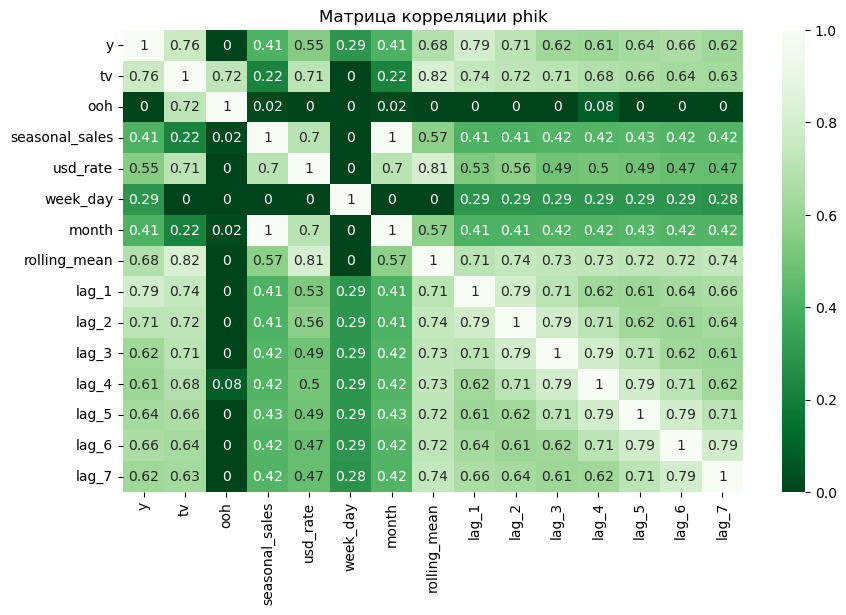

In [21]:
matrix = (data
          .phik_matrix(interval_cols=['usd_rate', 'y', 'rolling_mean',
                                      'lag_1', 'lag_2', 'lag_3', 'lag_4',
                                      'lag_5', 'lag_6', 'lag_7']).round(2))
plt.figure(figsize=(10,6))
sns.heatmap(data=matrix, annot=True, cmap='Greens_r')
plt.title('Матрица корреляции phik')
plt.show()

Интерпретация
- Признак tv коррелирует с целевым высоко;
- Курс доллара высоко коррелирует с целевым;
- День недели и месяц умеренно коррелируют с целевым;
- Скользящее среднее значительно коррелирует с целевым;
- Лаги высоко коррелируют с целевым;
- Обнаружена мультиколлинеарность месяца и нормированной оценки сезонности , поэтому удалим признак месяц.

In [22]:
data = data.drop(['month'], axis=1)
data.columns

Index(['y', 'tv', 'ooh', 'seasonal_sales', 'usd_rate', 'week_day',
       'rolling_mean', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6',
       'lag_7'],
      dtype='object')

#### Вывод по EDA
1. Распределения входных признаков
    - Общие моменты: Так как в OOH и TV значения нулевые, кроме некоторых промежутков, можем считать, что канал просто не использовался в остальное время: то есть не было размещено баннера с рекламой и/или рекламного ролика;
    - Курс доллара колебался до октября 2014, затем начал стремительно расти, это могло привести к изменению рынка и спроса;
    - TV: На графике видно, что было 3 серии показов рекламы по ТВ: в 1 квартале 2013, в июне-августе 2014, и осенью 2015. Внутри каждого промежутка OTS распределялось по-разному, но имело похожую форму. Это может указывать на различия в стратегии показа или изменения в вовлечённости аудитории;
    - OOH: На графике видно 15 промежутков, на которых отличные от нуля OTS. Причем, показатели OTS выше в марте 2013 и 2014, апреле 2014, а также в июле 2014. Это может указывать на тестирование разных комбинаций баннера и местоположения баннера, или с сезонными факторами, влияющими на охваты;
    - Показатель оценка сезонности четко демонстрирует цикличность графике: Оценка растет с августа, заканчивая рост пиком в октябре (оценка 1), в ноябре небольшой спад, и в декабре снова демонстрируется локальный пик (0.8), за которым следует резкий спад почти до нуля. Январь и февраль - самые неактивные месяцы, в марте наступает резкий рост почти до уровня оценки в декабре, но за ним следует плавный спад, с локальным минимумом в мае, в июне оценка немного повышается, но в июле снова падает почти к нулю. Сентябрь, октябрь и декабрь - лучшие месяцы с точки зрения сезонности.
2. Распределение целевого признака
    - Распределение похоже на нормальное, чуть скошенного влево. Среднее 23.6, медиана чуть меньше - 21, это связано с наличием больших значений - 75 и более;
    - В нашем распоряжении данные с января 2013 по январь 2015;
    - В конце 2014 года произошел небывалый рост, вслед за которым пришел сильный сезонный спад (январь и февраль худшие месяцы по оценке сезонности);
    - Из анализа сезонности внутри двух недель (первые 14 дней декабря 2014 как раз идеально две полные недели): Присутствует сезонность в разрезе недели: с понелельника по вторник (пик) происходит рост, который переходит в плавное падение до пятницы, но в субботу и воскресенье происходит резкий спад почти до нуля.
3. Созданы новые признаки
    1. Количество звоноков день назад (так как присутствует недельная сезонность);
    2. Скользящее среднее с шагом 7 (так как присутствует недельная сезонность);
    3. День недели;
    4. Месяц;
4. Корреляционный анализ данных
   - Признак tv коррелирует с целевым высоко;
    - Курс доллара высоко коррелирует с целевым;
    - День недели и месяц умеренно коррелируют с целевым;
    - Скользящее среднее значительно коррелирует с целевым;
    - Лаги высоко коррелируют с целевым;
    - Обнаружена мультиколлинеарность месяца и нормированной оценки сезонности , поэтому удалим признак месяц.

## Моделирование

Будем использовать линейную регрессию как базовую модель и LightGBM, так как у нас в основном количественные признаки. Для обучения будем использовать пайплайн, а для тюнинга гиперпараметров поиск по сетке (рандомизированный).

### Обучение модели

In [23]:
# Списки с названиями колонок
cat_features = ['seasonal_sales']
num_features = data.drop(['seasonal_sales', 'y'], axis=1).columns

In [24]:
# Список для тюнинга гиперпараметров
parameters = [
    {
        'models': [LGBMRegressor(verbose=-1, lambda_l2=5, bagging_freq=1, bagging_fraction=0.8)],
        'models__max_depth': range(2, 4),
        'models__num_leaves': range(2, 4),
        'models__min_split_gain': range(2, 6)
    },
    {
        'models': [LinearRegression()],
        'preprocessor__cat': [Pipeline(
            [
                ('ohe', OneHotEncoder(drop='first'))
            ]
        )]
    }
]

In [25]:
# Разделение на выборки
X_train, X_valid, y_train, y_valid = train_test_split(
    data.drop('y', axis=1),
    data['y'],
    test_size=0.1,
    shuffle=False
)

In [26]:
np.random.seed(42)
# Функция для обучения модели
def learn_model(params):

    
    # Пайплайн для обработки признаков и обучения модели
    data_preprocessor = ColumnTransformer(
        [
            ('cat', 'passthrough', cat_features),
            ('num', StandardScaler(), num_features)
        ],
        remainder='passthrough',
        verbose_feature_names_out=False
    )

    final_pipe = Pipeline(
        [
            ('preprocessor', data_preprocessor),
            ('models', LinearRegression())
        ]
    )

    
    # Для использования кросс-валидации для временных рядов, используем TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=3)

    
    # Поиск лучшей модели
    search = RandomizedSearchCV(
        final_pipe,
        params,
        cv=tscv,
        scoring='neg_mean_absolute_error',
        n_jobs=-1
    )

    
    search.fit(X_train, y_train)
    print(f'Лучшая модель: {search.best_estimator_}')
    print(
        f'MAE на кросс-валидации: {abs(search.best_score_)}')
    
    return search.best_estimator_


estimator = learn_model(parameters)

/opt/anaconda3/envs/pet/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/pet/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/pet/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/pet/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/pet/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warni

Лучшая модель: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat', 'passthrough',
                                                  ['seasonal_sales']),
                                                 ('num', StandardScaler(),
                                                  Index(['tv', 'ooh', 'usd_rate', 'week_day', 'rolling_mean', 'lag_1', 'lag_2',
       'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7'],
      dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('models',
                 LGBMRegressor(bagging_fraction=0.8, bagging_freq=1,
                               lambda_l2=5, max_depth=2, min_split_gain=2,
                               num_leaves=2, verbose=-1))])
MAE на кросс-валидации: 6.368882655638135


/opt/anaconda3/envs/pet/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/pet/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/pet/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Получена модель LGBMRegressor(bagging_fraction=0.8, bagging_freq=1, lambda_l2=5, max_depth=2, min_split_gain=2,num_leaves=2)), ее показатель МАЕ на кросс-валидации 6.4. 

### Проверка модели

Проведем оценку модели на валидационной выборке и проведем тестирование на адекватность. Для этой проверки будем использовать предсказание средним по тренировочной выборке.

In [27]:
# Предсказание заказов средним по трен. выборке
train_mean_orders_num = y_train.mean()
mean_prediction = np.ones(len(y_valid)) * train_mean_orders_num
mean_prediction_mae = mean_absolute_error(y_valid, mean_prediction)


model_prediction_mae = mean_absolute_error(y_valid, estimator.predict(X_valid))

y_train_yesterday = y_train.shift(1).dropna()
y_train_yesterday_mae = mean_absolute_error(y_train[1:], y_train_yesterday)
y_valid_yesterday = y_valid.shift(1).dropna()
y_valid_yesterday_mae = mean_absolute_error(y_valid[1:], y_valid_yesterday)


print(
    f'MAE при предсказании средним по тренировочной выборке: {mean_prediction_mae}'
)
print(
    f'MAE при предсказании модели на валидационной выборке: {model_prediction_mae}'
)
print(
    f'MAE при предсказании значением вчерашнего дня на трейне: {y_train_yesterday_mae}'
)
print(
    f'MAE при предсказании значением вчерашнего дня на валидационной выборке: {y_valid_yesterday_mae}'
)

MAE при предсказании средним по тренировочной выборке: 22.074374079528724
MAE при предсказании модели на валидационной выборке: 16.791531788490087
MAE при предсказании значением вчерашнего дня на трейне: 7.800884955752212
MAE при предсказании значением вчерашнего дня на валидационной выборке: 11.2


Ошибка модели на валидационной выборке значительно выше, чем на кросс-валидации. Это может говорить о переобучении, но мы использовали коэффицент регуляризации равный 5 и Bagging в модели, чтобы снизить переобучение, но это не дает значимого преимущества и переобучение совсем не снижается.

Так что пока делаем промежуточный вывод, что модель на 23% лучше предсказанием средней по тренировочной выборке, но она все еще либо сильно переобучена, либо плохо объясняет данные тренировочной выборки. Дополнительный анализ показывает, что при предсказании значением вчерашнего дня, МАЕ 7.8, а на кросс-валидации мы получили результат 6.4, а на валидационной выборке предсказание значением вчерашнего дня дает МАЕ 11.2, что лучше покзаателя нашей модели, это также может быть сигналом, что изменился тренд.


Для проверки предскажем моделью все значения целевого признака и сравним график с истинным распределением. **Красным пунктиром на графиках покажем, где заканчивается тренировочная и начинается валидационная выборка**.

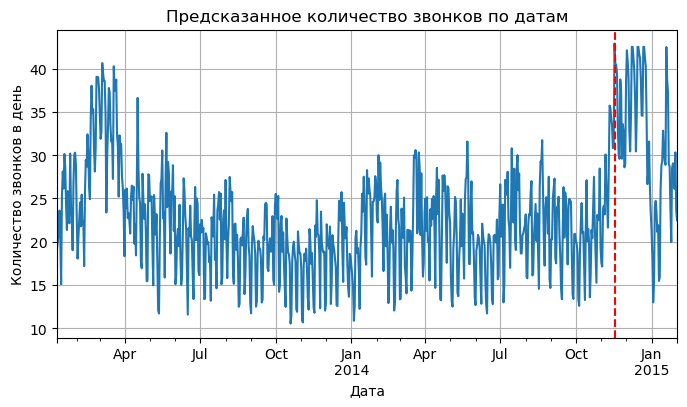

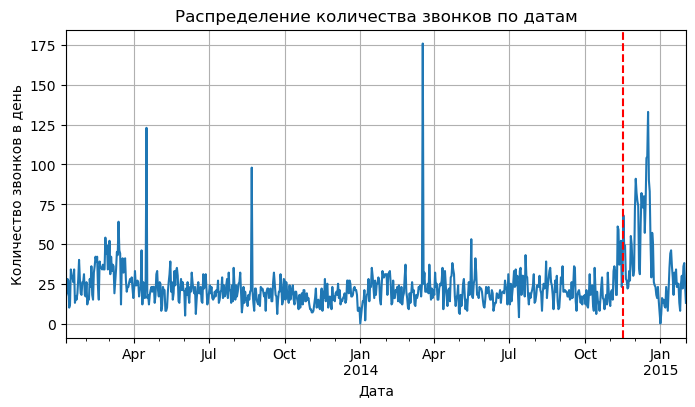

In [28]:
# Предсказываем все значения с помощью модели
data['y_predicted'] = estimator.predict(data.drop('y', axis=1))
data['y_predicted'].plot(figsize=(8,4))
plt.title('Предсказанное количество звонков по датам')
plt.ylabel('Количество звонков в день')
plt.xlabel('Дата')
plt.axvline(
    x=X_train.tail(1).index, ymin=0, color='red', linestyle='--'
)
plt.grid()
plt.show()


data['y'].plot(figsize=(8,4))
plt.title('Распределение количества звонков по датам')
plt.ylabel('Количество звонков в день')
plt.xlabel('Дата')
plt.axvline(
    x=X_train.tail(1).index, ymin=0, ymax=200, color='red', linestyle='--'
)
plt.grid()
plt.show()

Интерпретация графика
- Модель отлично предсказывает данные, выбросы не мешают строить адекватный прогноз, благодаря выбранной метрике;
- Четко видно, что начиная с ноября 2014 начинает меняться тренд: на исторических данных в пиковые месяцы 30-50 звонков в день, в то время как в 2014 это промежуток 50-130, такие значения модель видела только в выбросах, но они не могли стать основой для ее обучения, так как их очень мало, поэтому модель предсказывает в эти даты по 40 звонков, что значительно влияет на МАЕ на валидационной выборке;
- При предсказании значением вчерашнего дня МАЕ равна 7.8, а на кросс-валидации мы получили результат 6.4, это сигнал о смене тренда;

Тренд действительно мог измениться. Для подтверждения этой гипотезы будем использовать статистический тест.

### Проверка гипотезы о равенстве средних целевого признака тренировочной и валидационной выборок

- H0: средние тренировочной и валидационной выборок равны.
- H1: среднее валидационной выборки отлично от среднего тренировочной выборки.

Для проверки гипотезы будем использовать двухсторонний Т-test для независимых выборок.

In [29]:
# Установим более чувствительный уровень значимости
alpha = 0.01


pvalue = st.ttest_ind(y_train, y_valid).pvalue
print(f'p-value: {pvalue}')
if pvalue < alpha:
    print('Можем отклонить H0 в пользу H1')
else:
    print('Не можем отклонить H0 в пользу H1')

p-value: 4.1003518682569577e-23
Можем отклонить H0 в пользу H1


Статистический тест показал, что имеем достаточные основания, чтобы отклонить нулевую гипотезу о равенстве при уровне значимости 0.01. Дополнительно проведем анализ распределений.

/var/folders/m0/94b7zrt17lv3szp310d4y2bh0000gn/T/ipykernel_98332/2820653617.py:1: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([y_train, y_valid], labels=['train', 'valid'])


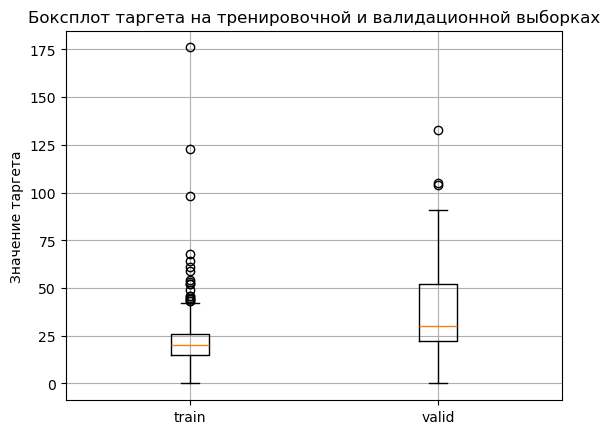

In [30]:
plt.boxplot([y_train, y_valid], labels=['train', 'valid'])
plt.ylabel('Значение таргета')
plt.title('Боксплот таргета на тренировочной и валидационной выборках')
plt.grid()
plt.show()

Боксплоты отличаются значительно: среднее на валидационной выше, межквартильный размах от 24 до 51, а на тренировочной 12-26. Распределения отличаются.

### Объяснение модели

Проведем анализ важности признаков с помощью shap.beeswarm.

PermutationExplainer explainer: 680it [00:22, 18.84it/s]                        


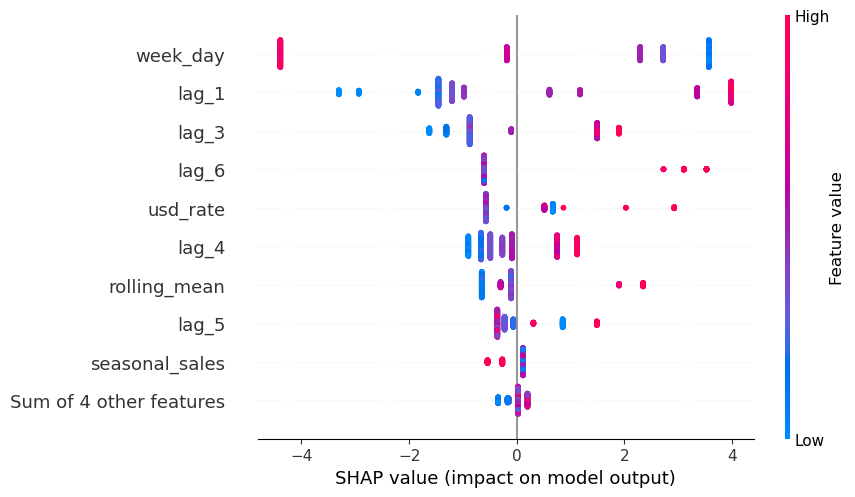

In [31]:
# Обработаем данные препроцессором лучшей модели
X_train_encoded = pd.DataFrame(data=estimator['preprocessor'].transform(
    X_train), columns=estimator['preprocessor'].get_feature_names_out())


explainer = shap.PermutationExplainer(
    model=estimator['models'].predict,
    data=X_train_encoded,
    feature_name=estimator['preprocessor'].get_feature_names_out(),
    masker=shap.maskers.Independent(X_train_encoded)
)
shap_values = explainer(X_train_encoded)
shap.plots.beeswarm(shap_values)

Интерпретация графика
- Самый сильный признак - день недели. В выходные звонков значительно меньше, чем в будни;
- Лаги и скользящее среднее сильно влияют на количество звонков. Это значит, что есть сезонность внутри недели;
- Так как влияние признака TV не входит в топ-9 важных признаков, считаем, что OTS на телевидении не влияет на целевую переменную значительно;

#### Вывод по моделированию
- Получена модель LGBMRegressor(bagging_fraction=0.8, bagging_freq=1, lambda_l2=5, max_depth=2, min_split_gain=2,num_leaves=2)), ее показатель МАЕ на кросс-валидации 6.4. МАЕ на валидационной выборке 16.7, на 23% лучше предсказания средним тренировочной выборки, но хуже предсказания значением вчерашнего дня;
- Получены статистические выводы о том, что средние в тренировочной и валидационной выборке отличаются, выводы подкрепляются анализом боксплотов и сравнением графиков истинного значения таргета и предсказанного моделью;
- Чтобы улучшить качество модели, необходимо больше данных за 2015 год, возможно тренды конца 2014 продолжатся, и можно будет построить и обучить более сильную модель; Также на улучшение качества модели для анализа спроса могут повлиять дополнительные признаки, например, количество писем на почту, активность менеджеров по продажам и анализ других маркетинговых инструментов. Ведь компания могла нанять в конце 2014 целый колл-центр для привлечения, и количество звонков увеличилось в связи с увеличением количества исходящих звонков.
- Анализ признаков:
    - Самый сильный признак - день недели. В выходные звонков значительно меньше, чем в будни;
    - Лаги и скользящее среднее сильно влияют на количество звонков. Это значит, что есть сезонность внутри недели;
    - Так как влияние признака TV не входит в топ-9 важных признаков, считаем, что OTS на телевидении не влияет на целевую переменную значительно;

### Оценка влияния показов на ТВ

Создадим бинарный признак, который позволит нам отделить дни с показами по ТВ и без показов, чтобы оценить влияние признака на количество звонков.

#### Анализ боксплотов

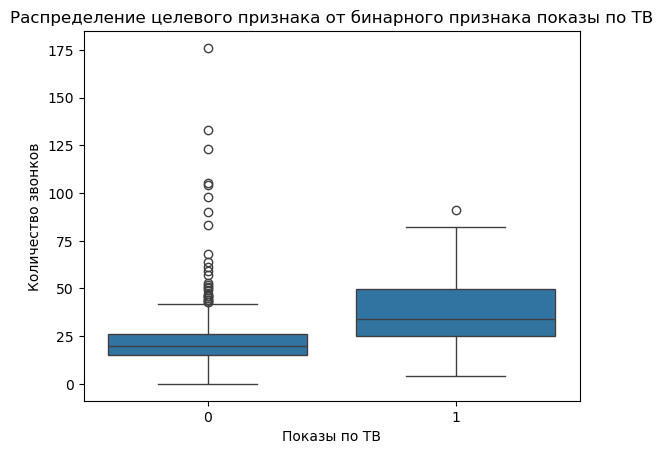

In [32]:
data['tv_binary'] = data['tv'].apply(lambda x: 1 if x > 0 else 0)
sns.boxplot(data=data, x='tv_binary', y='y')
plt.xlabel('Показы по ТВ')
plt.title('Распределение целевого признака от бинарного признака показы по ТВ')
plt.ylabel('Количество звонков')
plt.show()

Графики боксплот выглядят разными: при значении tv 1 межквартильный размах больше - от 25 до 50, в то время как при значении 0 от 12 до 25, медиана и среднее также отличаются.

Проведем Т-test для независимых выборок, чтобы статистически доказать отличие средних.

#### Проверка статистической гипотезы

- H0: Среднее значений звонков в день, когда по ТВ показывали рекламу, равно среднему значению в дни, когда рекламу по ТВ не показывали;
- H1: Среднее значений звонков в день, когда по ТВ показывали рекламу, больше среднего значения в дни, когда рекламу по ТВ не показывали;

In [33]:
alpha = 0.01


tv_applied = data[data['tv_binary'] == 1]['y']
tv_not_applied = data[data['tv_binary'] == 0]['y']
pvalue = st.ttest_ind(tv_applied, tv_not_applied).pvalue
print(f'p-value: {pvalue}')
if pvalue < alpha:
    print('Можем отклонить H0 в пользу H1')

p-value: 5.752514710939134e-18
Можем отклонить H0 в пользу H1


**Вывод:**

Статистический тест и анализ боксплотов позволяют сделать вывод о том, что показы по телевидению повышают количество звонков.

## Отчет по исследованию

### Задача
Построить модель предсказания количества телефонных звонков неуникальных потенциальных покупателей в справочные дилерских центров в зависимости от входных признаков - OTS по двум рекламным каналам, оценка сезонности и курс доллара.

### Результаты разведочного анализа данных
1. Распределения входных признаков
    - Общие моменты: Так как в OOH и TV значения нулевые, кроме некоторых промежутков, можем считать, что канал просто не использовался в остальное время: то есть не было размещено баннера с рекламой и/или рекламного ролика;
    - Курс доллара колебался до октября 2014, затем начал стремительно расти, это могло привести к изменению рынка и спроса;
    - TV: На графике видно, что было 3 серии показов рекламы по ТВ: в 1 квартале 2013, в июне-августе 2014, и осенью 2015. Внутри каждого промежутка OTS распределялось по-разному, но имело похожую форму. Это может указывать на различия в стратегии показа или изменения в вовлечённости аудитории;
    - OOH: На графике видно 15 промежутков, на которых отличные от нуля OTS. Причем, показатели OTS выше в марте 2013 и 2014, апреле 2014, а также в июле 2014. Это может указывать на тестирование разных комбинаций баннера и местоположения баннера, или с сезонными факторами, влияющими на охваты;
    - Показатель оценка сезонности четко демонстрирует цикличность графике: Оценка растет с августа, заканчивая рост пиком в октябре (оценка 1), в ноябре небольшой спад, и в декабре снова демонстрируется локальный пик (0.8), за которым следует резкий спад почти до нуля. Январь и февраль - самые неактивные месяцы, в марте наступает резкий рост почти до уровня оценки в декабре, но за ним следует плавный спад, с локальным минимумом в мае, в июне оценка немного повышается, но в июле снова падает почти к нулю. Сентябрь, октябрь и декабрь - лучшие месяцы с точки зрения сезонности.
2. Распределение целевого признака
    - Распределение похоже на нормальное, чуть скошенного влево. Среднее 23.6, медиана чуть меньше - 21, это связано с наличием больших значений - 75 и более;
   - В нашем распоряжении данные с января 2013 по январь 2015;
    - В конце 2014 года произошел небывалый рост, вслед за которым пришел сильный сезонный спад (январь и февраль худшие месяцы по оценке сезонности);
    - Из анализа сезонности внутри двух недель (первые 14 дней декабря 2014 как раз идеально две полные недели): Присутствует сезонность в разрезе недели: с понелельника по вторник (пик) происходит рост, который переходит в плавное падение до пятницы, но в субботу и воскресенье происходит резкий спад почти до нуля.

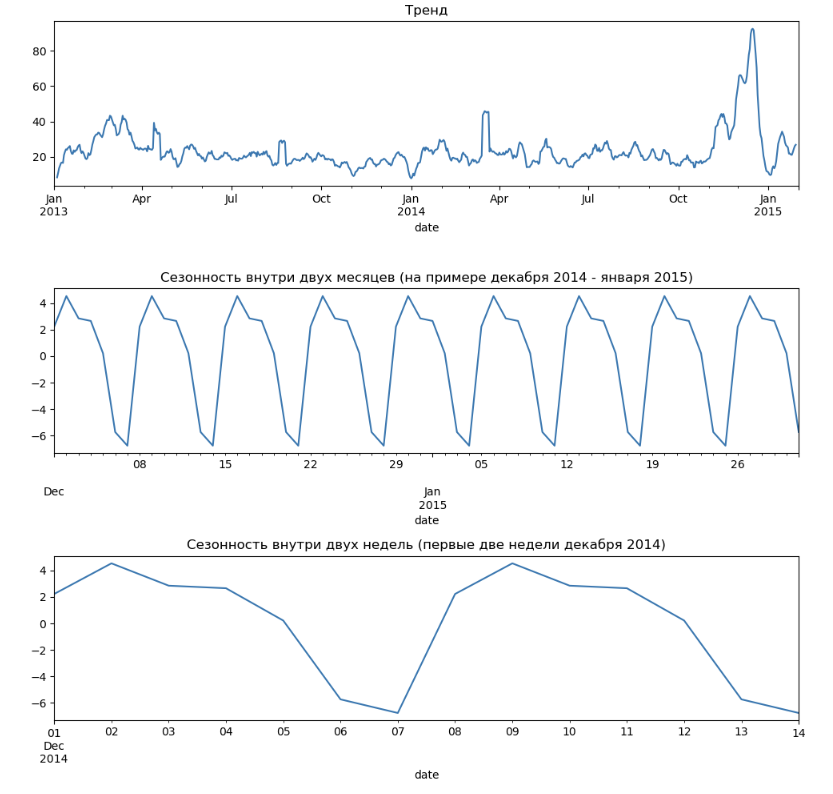

4. Добавлены признаки
    1. Количество звоноков день назад (так как присутствует недельная сезонность);
    2. Скользящее среднее с шагом 7 (так как присутствует недельная сезонность);
    3. День недели;
5. Корреляционный анализ данных
    - Признак tv коррелирует с целевым высоко;
    - Курс доллара очень сильно коррелирует с целевым;
    - День недели и месяц умеренно коррелируют с целевым;
    - Скользящее среднее очень сильно коррелирует с целевым;
    - Лаги высоко коррелируют с целевым.


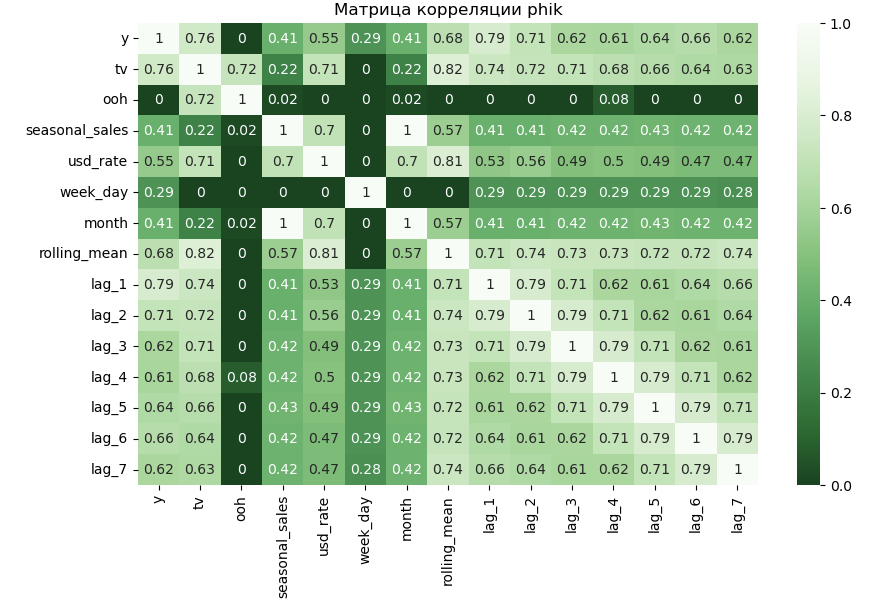


### Анализ модели
- Получена модель LGBMRegressor(bagging_fraction=0.8, bagging_freq=1, lambda_l2=5, max_depth=2, min_split_gain=2,num_leaves=2)), ее показатель МАЕ на кросс-валидации 6.4. МАЕ на валидационной выборке 16.7, на 23% лучше предсказания средним тренировочной выборки, но хуже предсказания значением вчерашнего дня;


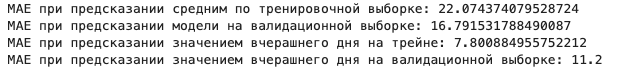

- Получены статистические выводы о том, что распределение целевого признака в тренировочной и валидационной выборке отличаются, выводы подкрепляются анализом боксплотов и сравнением графиков истинного значения таргета и предсказанного моделью;

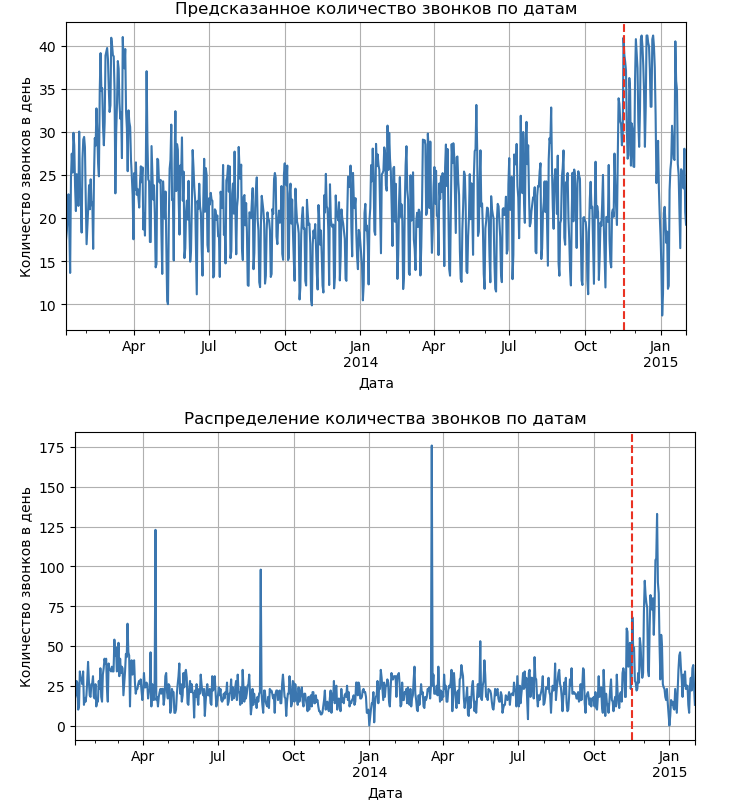

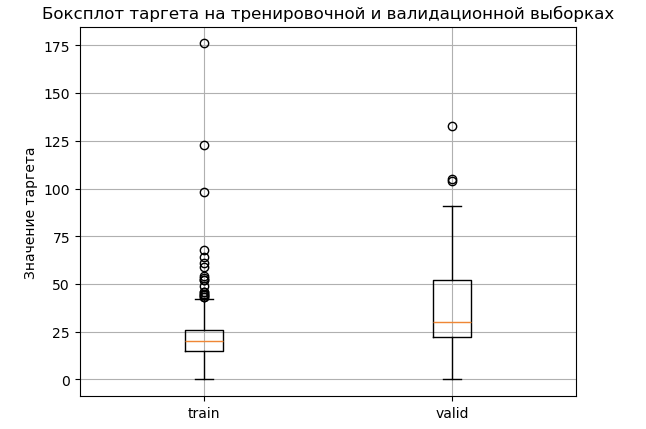


- Чтобы улучшить качество модели, необходимо больше данных за 2015 год, возможно тренды конца 2014 продолжатся, и можно будет построить и обучить более сильную модель; Также на улучшение качества модели для анализа спроса могут повлиять дополнительные признаки, например, количество писем на почту, активность менеджеров по продажам и анализ других маркетинговых инструментов. Ведь компания могла нанять в конце 2014 целый колл-центр для привлечения, и количество звонков увеличилось в связи с увеличением количества исходящих звонков.
- Анализ признаков:
    - Самый сильный признак - день недели. В выходные звонков значительно меньше, чем в будни;
    - Лаги и скользящее среднее сильно влияют на количество звонков.

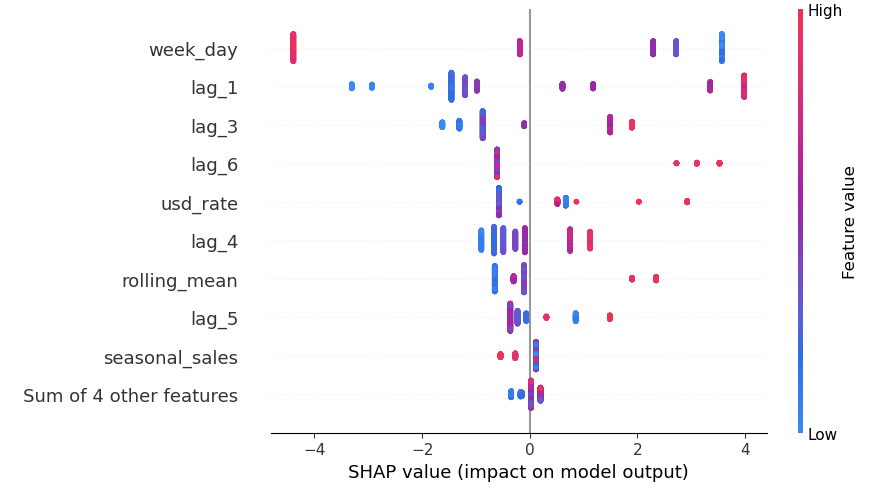

## Рекомендации для заказчика
- Рекомендуем заказчику собрать данные хотя бы за первое полугодие 2015, и заново обучить модель, так как результаты анализа заключают о смене тренда в конце 2014.
- Модель можно применять для предсказания количества звонков, если всплеск осенью-зимой 2014 окажется выбросом или аномалиями, то есть если по результату первого квартала 2015 тренд будет аналогичный, как в 2014 и в 2013.
- Показы по телевидению повышают количество звонков. Для повышения количества звоноков рекомендуем продвижение через телевидение.